In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

from IS2ML_utils import *
from figscode import *

import statsmodels.api as sm

def get_ordered_groups(group_size, length):
    np.random.seed(42)
    n_groups, remainder = divmod(length, group_size)
    n_add, remainder = divmod(remainder, n_groups)
    lengthlist = [n_add+1] * remainder + [n_add] * (n_groups - remainder)
    np.random.shuffle(lengthlist)
    addlist = group_size + np.array(lengthlist)
    groups = []
    for i, j in enumerate(addlist):
        groups += [i] * j
    return groups

In [55]:
gdf_basins = gpd.read_file('data/shapefiles/ANT_basins_merged.shp')
gdf_imbie = gpd.read_file('data/shapefiles/Basins_Antarctica_v02.shp')
gdf_shelf = gpd.read_file('data/shapefiles/IceShelf_Antarctica_v02.shp')
gdf_coast = gpd.read_file('data/shapefiles/Coastline_Antarctica_v02.shp')
gdf_gl = gpd.read_file('data/shapefiles/GroundingLine_Antarctica_v02.shp')
gdf_names = pd.concat((gdf_imbie.drop(columns=['Asso_Shelf', 'Subregions']),
                       gdf_shelf)).reset_index(drop=True)

fn_lakestats = 'data/FLUID-SuRRF_AIS2019-23_lakestats.csv'
df = pd.read_csv(fn_lakestats)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs=gdf_basins.crs)
if ('dist_GL' not in gdf.keys()) or ('dist_coast' not in gdf.keys()):
    gdf['dist_GL'] = gdf.geometry.distance(gdf_gl.boundary.iloc[0])
    gdf.loc[gdf.grounded, 'dist_GL'] *= -1
    gdf['dist_coast'] = gdf.geometry.distance(gdf_coast.boundary.iloc[0])
    gdf.to_csv(fn_lakestats, index=False)
    

In [196]:
wais_corr = gpd.read_file('data/zzz_temp/corr/WAIS_Jan_2017_Polygons.shp')
eais_stokes = gpd.read_file('data/zzz_temp/stokes/Jan_2017_Lakes.shp')

0.008303111280778775

In [213]:
c1000 = wais_corr.Elevation <= 1000
s1000 = eais_stokes.Elevation <= 1000
area1000_stokes = eais_stokes.Area[s1000].sum() / eais_stokes.Area.sum() * 100
area1000_corr =  wais_corr.Area[c1000].sum() / wais_corr.Area.sum() * 100
print('%.1f%% of lake area is < 1000m for EAIS (Stokes et al., 2019)' % area1000_stokes)
print('%.1f%% of lake area is < 1000m for WAIS (Corr et al., 2022)' % area1000_corr)
print('\n%.1f%% of lakes are < 1000m for EAIS (Stokes et al., 2019)' % (s1000.mean()*100))
print('%.1f%% of lakes are < 1000m for WAIS (Corr et al., 2022)' % (c1000.mean()*100))

99.7% of lake area is < 1000m for EAIS (Stokes et al., 2019)
99.6% of lake area is < 1000m for WAIS (Corr et al., 2022)

99.6% of lakes are < 1000m for EAIS (Stokes et al., 2019)
99.2% of lakes are < 1000m for WAIS (Corr et al., 2022)


In [209]:
(wais_corr.Elevation > 1000).mean()

0.008303111280778775

In [210]:
(eais_stokes.Elevation > 1000).mean()

0.004185826242380727

In [199]:
eais_stokes

65459

In [200]:
len(wais_corr)

10478

# Print some overall statistics from the dataset

In [188]:
df_stats = pd.read_csv('data/FLUID-SuRRF_AIS2018-23_groupstats.csv')
df_stats['depth_print'] = df_stats.depth_90pctl.apply(lambda x: '$%.1f$' % x)
df_stats['elev_print'] = df_stats.elev_mean.apply(lambda x: '$%.0f$' % x)
# df_stats['doy_print'] = df_stats.doy_mean.apply(lambda x: (datetime(2019, 1, 1) + timedelta(days=x-1)).strftime("%b %d"))
df_stats['percent_water_print'] = df_stats.pct_xatc_water.apply(lambda x: '$%.1g$' % x)
df_stats['ngranules_print'] = df_stats.n_granules.apply(lambda x: '$%.0f$' % x)
df_stats['qual_print'] = df_stats.qual_median.apply(lambda x: '$%.2f$' % x)

In [190]:
totals = df_stats[df_stats.group=='total'].iloc[0]
print('In total, we processed %i granules over Greenland.' % totals.n_granules)
print('with a total size of %.0f TB' % (totals.data_mb/1e6))
print('Comprising %.0f million kilometers of along-track data' % (totals.xatc_total_m/1e9))
print('and about %.0f billion geolocated photons.' % (totals.nphot_total/1e9))
print('\nIn total, %.2g%% of along-track distance was surface of supraglacial lakes with visible lakebed.' % totals.pct_xatc_water)
print('amounting to %.0f km of along-track lake depth data' % (totals.xatc_water/1e3))
print('mean of >90th percentile depth: %.3g m' % totals.depth_90pctl)
print('mean elevation: %.0f m' % totals.elev_mean)
print('mean date: %s' % totals.doy_str)
display(df_stats)

In total, we processed 42752 granules over Greenland.
with a total size of 107 TB
Comprising 55 million kilometers of along-track data
and about 594 billion geolocated photons.

In total, 0.0039% of along-track distance was surface of supraglacial lakes with visible lakebed.
amounting to 2117 km of along-track lake depth data
mean of >90th percentile depth: 5.7 m
mean elevation: 134 m
mean date: Jan 21


,group,xatc_total_m,nphot_total,data_mb,n_granules,n_lakes,n_lakes_depth,xatc_water,pct_xatc_water,depth_90pctl,elev_mean,qual_median,doy_mean,doy_str,depth_print,elev_print,percent_water_print,ngranules_print,qual_print
0,total,5.467696e+10,5.940318e+11,1.068368e+08,42752,3559,2118,2117325.0,0.003872,5.698306,133.564781,1.071876,21.121382,Jan 21,$5.7$,$134$,$0.004$,$42752$,$1.07$
1,2018-19,1.082641e+10,1.142670e+11,1.804596e+07,8434,1147,703,747960.0,0.006909,4.873082,142.638606,1.146657,11.000000,Jan 11,$4.9$,$143$,$0.007$,$8434$,$1.15$
2,2019-20,1.120923e+10,1.132542e+11,2.121775e+07,8701,1022,627,655090.0,0.005844,6.512125,119.368964,1.207474,30.000000,Jan 30,$6.5$,$119$,$0.006$,$8701$,$1.21$
3,2020-21,1.077093e+10,1.228087e+11,2.251388e+07,8484,460,240,225465.0,0.002093,6.029893,135.898929,0.838368,20.000000,Jan 20,$6.0$,$136$,$0.002$,$8484$,$0.84$
4,2021-22,1.098725e+10,1.254473e+11,2.296016e+07,8629,569,348,296485.0,0.002698,5.093209,172.170806,1.174860,18.000000,Jan 18,$5.1$,$172$,$0.003$,$8629$,$1.17$
5,2022-23,1.088314e+10,1.182546e+11,2.209902e+07,8504,361,200,192325.0,0.001767,6.202128,81.099164,0.711970,29.000000,Jan 29,$6.2$,$81$,$0.002$,$8504$,$0.71$
6,East,2.258627e+10,2.799528e+11,5.828950e+07,22473,2947,1755,1787340.0,0.007913,5.551815,148.807814,1.118342,17.000000,Jan 17,$5.6$,$149$,$0.008$,$22473$,$1.12$
7,Peninsula,3.888936e+09,6.001780e+10,7.333658e+06,2184,530,319,282185.0,0.007256,6.582306,39.040831,0.818437,35.000000,Feb 04,$6.6$,$39$,$0.007$,$2184$,$0.82$
8,West,2.820176e+10,2.540612e+11,4.121361e+07,18095,82,44,47800.0,0.000169,4.599640,196.692536,1.148706,2.000000,Jan 02,$4.6$,$197$,$0.0002$,$18095$,$1.15$
9,A-Ap,2.620883e+09,3.943233e+10,6.783670e+06,2664,256,118,187180.0,0.007142,5.301472,56.499775,0.774608,21.000000,Jan 21,$5.3$,$56$,$0.007$,$2664$,$0.77$


<Axes: >

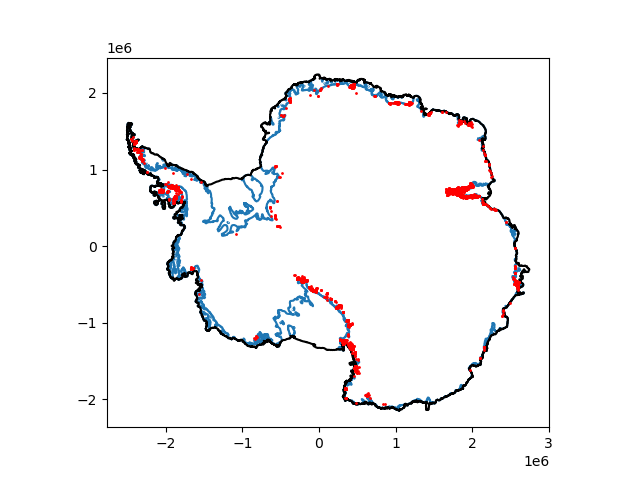

In [52]:
plt.close('all')
fig, ax = plt.subplots()
gdf_gl.boundary.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=1, zorder=10)
gdf_coast.boundary.plot(ax=ax, color='k')

In [22]:
gdf_gl.boundary

0    MULTILINESTRING ((-217776.532 2130382.522, -21...
dtype: geometry

Text(0, 0.5, 'total along-track water extent (km)')

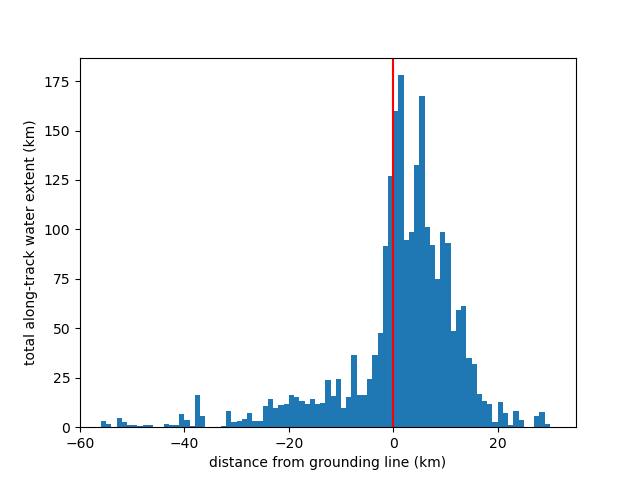

In [50]:
fig, ax = plt.subplots()
xl = [-60, 35]
# bins = np.linspace(xl[0], xl[1], )
bins = np.arange(xl[0], xl[1]+1)
ax.hist(gdf.dist_GL/1000, bins=bins, weights=gdf.length_water/1000);
ax.axvline(0, color='red')
ax.set_xlim((-60, 35))
ax.set_xlabel('distance from grounding line (km)')
ax.set_ylabel('total along-track water extent (km)')

Text(0, 0.5, 'total along-track water extent (km)')

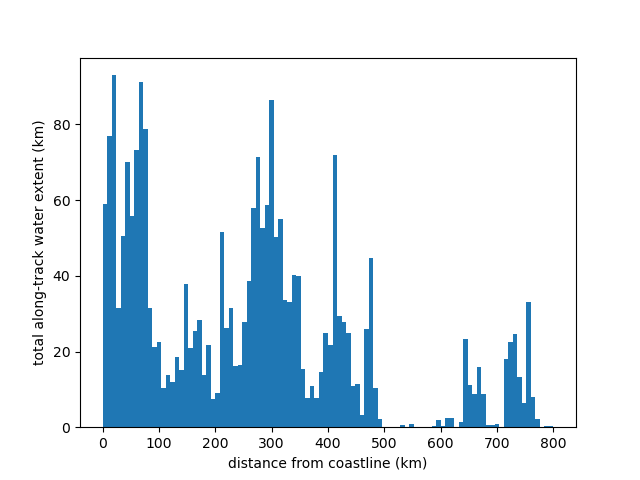

In [57]:
fig, ax = plt.subplots()
xl = [-60, 35]
# bins = np.linspace(xl[0], xl[1], )
bins = np.arange(xl[0], xl[1]+1)
ax.hist(gdf.dist_coast/1000, bins=100, weights=gdf.length_water/1000);
ax.set_xlabel('distance from coastline (km)')
ax.set_ylabel('total along-track water extent (km)')

In [183]:
# fn_stats = 'data/FLUID-SuRRF_AIS2019-23_lakestats.csv'
# df = pd.read_csv(fn_stats)
# df['geometry'] = df['geometry'].apply(wkt.loads)
# gdf = gpd.GeoDataFrame(df, crs=gdf_basins.crs)
# gdf['lid'] = gdf.apply(lambda x: '_'.join(x.lake_id.split('_')[4:]), axis=1)

# def get_robust_depth(r):
#     fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
#     with h5py.File(fn, 'r') as f:
#         if 'depth_data' in f.keys():
#             df = pd.DataFrame({k: f['depth_data'][k][()] for k in f['depth_data'].keys()})
#             resolution = 5.0
#             dfd = df[df.depth>0]
#             dfd = dfd[dfd.conf>0.4]
#             if len(dfd) > 10:
#                 return dfd.depth.quantile(0.95)
#             else:
#                 return 0.0
#         else:
#             return np.nan

# if 'rdepth' not in gdf.keys():
#     gdf['rdepth'] = gdf.apply(get_robust_depth, axis=1)
#     gdf.to_csv(fn_stats)

# is_good = (gdf.label=='good_lake') & (~gdf.rdepth.isna())
# gdfg = gdf[is_good].copy().reset_index(drop=True)
# gdfng = gdf[~is_good].copy().reset_index(drop=True)
# gdfnnz = gdfg[gdfg['rdepth']>0]

# dfgranules = pd.read_csv('data/FLUID-SuRRF_AIS2018-23_granulestats.csv')
# dfgranules['main_region'] = dfgranules.polygon.apply(lambda x: x.split('_')[3])

# cols_rename = {'length_granule_xatc_meters': 'xatc_total_m',
#                'number_photons_granule': 'nphot_total',
#                'size_mb': 'data_mb',
#               }
# col_grp = 'basin'
# df_grps = dfgranules.copy().rename(columns={col_grp: 'group'}).groupby('group')[list(cols_rename)].sum().rename(columns=cols_rename)
# df_grps['n_granules'] = dfgranules.groupby(col_grp)['granule_id'].count()
# df_grps['region'] = dfgranules.groupby(col_grp)['main_region'].first()
# df_grps = df_grps.reset_index().sort_values(by=['region', 'group']).set_index('group')# .drop(columns=['region'])

# dftot = pd.DataFrame(df_grps.sum()).transpose()
# dftot['group'] = 'total'
# dftot = dftot.set_index('group', drop=True).drop(columns=['region'])

# dfreg = df_grps.groupby('region').sum().rename_axis('group')

# col_grp = 'melt_season'
# df_yrs = dfgranules.rename(columns={col_grp: 'group'}).groupby('group')[list(cols_rename)].sum().rename(columns=cols_rename)
# df_yrs['n_granules'] = dfgranules.groupby(col_grp)['granule_id'].count()

# df_grps = df_grps.drop(columns='region')
# df_grps = pd.concat((dftot, df_yrs, dfreg, df_grps))

# groupbys = ['region', 'basin', 'melt_season']

# # number of lakes
# colname = 'n_lakes'
# col = 'ice_sheet'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].count()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].count()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps.loc[df_grps[colname].isna(), colname] = 0.0
# df_grps[colname] = df_grps[colname].astype(int)

# # number of lakes
# colname = 'n_lakes_depth'
# col = 'ice_sheet'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfnnz[col].count()
# for groupby in groupbys: 
#     vals_grouped = gdfnnz.groupby(groupby)[col].count()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps.loc[df_grps[colname].isna(), colname] = 0.0
# df_grps[colname] = df_grps[colname].astype(int)

# # xatc water and percentage
# colname = 'xatc_water'
# col = 'length_water'
# groupbys = ['region', 'basin', 'melt_season']
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].sum()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].sum()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps.loc[df_grps[colname].isna(), colname] = 0.0
# df_grps['pct_xatc_water'] = df_grps.xatc_water / df_grps.xatc_total_m * 100

# # depth mean of top 10%
# quant = 0.9
# colname = 'depth_%ipctl' % int(np.round(quant*100))
# col = 'rdepth'
# df_grps.loc['total', colname] = gdfnnz[col][gdfnnz[col] > gdfnnz[col].quantile(quant)].mean()
# for groupby in groupbys: 
#     vals_grouped = gdfnnz.groupby(groupby)[col].apply(lambda x: x[x>=x.quantile(quant)].mean())
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps

# # mean elevation
# colname = 'elev_mean'
# col = 'surface_elevation'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].mean()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].mean()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped

# colname = 'qual_median'
# col = 'depth_quality_sort'
# # col = 'qual_clip'
# # gdfnnz['qual_clip'] = gdfnnz.depth_quality_sort.clip(0,5)
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfnnz[col].median()
# for groupby in groupbys: 
#     vals_grouped = gdfnnz.groupby(groupby)[col].median()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped

# # NOTE: SOME DATES ARE PLACE IN AUGUST??? 
# # I CHECKED AND THE ERROR MUST BE IN THE ACTUAL DELTA TIME VALUES IN THE MFRAME-LEVEL DATA
# # WILL DO SOME DIGGING AND SEE IF THE ERROR IS IN THE ACTUAL DATA OR IN THE FLUIDSURRF CODE
# # I ASSUME IT'S IN THE DATA SOMEHOW?
# dtformat = '%Y-%m-%dT%H:%M:%SZ'
# gdfg['datetime'] = gdfg.date_time.apply(lambda x: datetime.strptime(x, dtformat))
# def is_leap_year(year):
#     return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
# def get_doy(x):
#     doy = x.timetuple().tm_yday
#     if is_leap_year(x.year):
#         if doy == 60: # feb 29
#             doy = np.nan
#         if doy > 60:
#             doy -= 1
#     return doy
# gdfg['doy'] = gdfg.datetime.apply(get_doy)
# doy_start = datetime(2019, 11, 1).timetuple().tm_yday
# doy_end = datetime(2019, 3, 31).timetuple().tm_yday
# inside_doy_range = (gdfg.doy >= doy_start) | (gdfg.doy <= doy_end)
# gdfg.loc[~inside_doy_range, 'doy'] = np.nan
# gdfg.loc[gdfg.doy > 200, 'doy'] -= 365
# colname = 'doy_mean'
# col = 'doy'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].mean()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].median()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped

# df_grps.loc[df_grps.doy_mean < 0, 'doy_mean'] += 365
# df_grps['doy_str'] = 'none'
# df_grps.loc[~df_grps.doy_mean.isna(), 'doy_str'] = df_grps.doy_mean[~df_grps.doy_mean.isna()].apply(lambda x: (datetime(2019, 1, 1) + timedelta(days=x-1)).strftime("%b %d"))


# df_grps
# fn_out_groupstats = 'data/FLUID-SuRRF_AIS2018-23_groupstats.csv'
# df_grps.to_csv(fn_out_groupstats)
# display(df_grps)

,xatc_total_m,nphot_total,data_mb,n_granules,n_lakes,n_lakes_depth,xatc_water,pct_xatc_water,depth_90pctl,elev_mean,qual_median,doy_mean,doy_str
group,,,,,,,,,,,,,
total,54676961254.587997,594031787526.0,106836775.197319,42752,3559,2118,2117325.0,0.003872,5.698306,133.564781,1.071876,21.121382,Jan 21
2018-19,10826407439.405001,114267018739.0,18045962.84269,8434,1147,703,747960.0,0.006909,4.873082,142.638606,1.146657,11.000000,Jan 11
2019-20,11209230185.145,113254185954.0,21217749.318849,8701,1022,627,655090.0,0.005844,6.512125,119.368964,1.207474,30.000000,Jan 30
2020-21,10770933719.708,122808659760.0,22513879.377692,8484,460,240,225465.0,0.002093,6.029893,135.898929,0.838368,20.000000,Jan 20
2021-22,10987251355.905001,125447339205.0,22960162.219295,8629,569,348,296485.0,0.002698,5.093209,172.170806,1.174860,18.000000,Jan 18
2022-23,10883138554.424999,118254583868.0,22099021.438794,8504,361,200,192325.0,0.001767,6.202128,81.099164,0.711970,29.000000,Jan 29
East,22586268158.609001,279952792934.0,58289502.453985,22473,2947,1755,1787340.0,0.007913,5.551815,148.807814,1.118342,17.000000,Jan 17
Peninsula,3888936194.433,60017800640.0,7333658.098387,2184,530,319,282185.0,0.007256,6.582306,39.040831,0.818437,35.000000,Feb 04
West,28201756901.546001,254061193952.0,41213614.644947,18095,82,44,47800.0,0.000169,4.599640,196.692536,1.148706,2.000000,Jan 02


In [185]:
base_dir = '../GLD3_complete/AIS/'
context_dir = 'detection_context/'
imagery_dir = 'detection_imagery/'
data_dir = 'detection_out_data/'
plot_dir = 'detection_out_plot/'
def get_datetime(r):
    fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
    with h5py.File(fn, 'r') as f:
        if 'mframe_data' in f.keys():
            return convert_time_to_string(np.mean(f['mframe_data']['dt'][()]))

dttest = gdfg.apply(get_datetime, axis=1)
notsame = dttest != gdfg.date_time
notsame.sum()

0